# DeepLab Demo

This demo will demostrate the steps to run deeplab semantic segmentation model on sample input images.

## Prerequisites

Running this demo requires the following libraries:

* Jupyter notebook (Python 2)
* Tensorflow (>= v1.5.0)
* Matplotlib
* Pillow
* numpy
* ipywidgets (follow the setup [here](https://ipywidgets.readthedocs.io/en/stable/user_install.html))

## Imports

In [11]:
import collections
import os
import io
#import StringIO
import sys
import tarfile
import tempfile
import glob
import urllib
import cv2

from IPython import display
from ipywidgets import interact
from ipywidgets import interactive
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image, ImageOps

import tensorflow as tf

if tf.__version__ < '1.5.0':
    raise ImportError('Please upgrade your tensorflow installation to v1.5.0 or newer!')

# Needed to show segmentation colormap labels
sys.path.append('utils')
import get_dataset_colormap

## Select and download models

In [2]:
_MODEL_URLS = {
    'xception_coco_voctrainaug': 'http://download.tensorflow.org/models/deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval': 'http://download.tensorflow.org/models/deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}

Config = collections.namedtuple('Config', 'model_url, model_dir')

def get_config(model_name, model_dir):
    return Config(_MODEL_URLS[model_name], model_dir)

config_widget = interactive(get_config, model_name=_MODEL_URLS.keys(), model_dir='')
display.display(config_widget)

interactive(children=(Dropdown(description='model_name', options=('xception_coco_voctrainaug', 'xception_coco_voctrainval'), value='xception_coco_voctrainaug'), Text(value='', description='model_dir'), Output()), _dom_classes=('widget-interact',))

In [3]:
# Check configuration and download the model

_TARBALL_NAME = 'deeplab_model.tar.gz'

config = config_widget.result

model_dir = config.model_dir or tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)


## Load model in TensorFlow

In [149]:
_FROZEN_GRAPH_NAME = 'frozen_inference_graph'


class DeepLabModel(object):
    """Class to load deeplab model and run inference."""
    
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513

    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()
        
        graph_def = None
        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if _FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read())
                break

        tar_file.close()
        
        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():      
            tf.import_graph_def(graph_def, name='')
        
        self.sess = tf.Session(graph=self.graph)
            
    def run(self, image):
        """Runs inference on a single image.
        
        Args:
            image: A PIL.Image object, raw input image.
            
        Returns:
            resized_image: RGB image resized from original input image.
            seg_map: Segmentation map of `resized_image`.
        """
        width, height = image.size
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        #resized_image.save('resized.jpg')
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]
        return resized_image, seg_map


In [150]:
print(glob.glob('models/*'))
model = DeepLabModel(glob.glob('models/*')[1])

['models\\deeplabv3_cityscapes_train_2018_02_06.tar.gz', 'models\\deeplabv3_pascal_trainval_2018_01_04.tar.gz', 'models\\deeplabv3_pascal_train_aug_2018_01_04.tar.gz', 'models\\opencv', 'models\\opencv-3.4.1-vc14_vc15.exe']


## Helper methods

In [17]:
LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog',
    'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa',
    'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = get_dataset_colormap.label_to_color_image(FULL_LABEL_MAP)


def vis_segmentation(image, seg_map):
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')
    
    plt.subplot(grid_spec[1])
    seg_image = get_dataset_colormap.label_to_color_image(
        seg_map, get_dataset_colormap.get_pascal_name()).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')
    
    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0)
    plt.show()

In [18]:
LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog',
    'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa',
    'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = get_dataset_colormap.label_to_color_image(FULL_LABEL_MAP)


def seg_save(image, seg_map, url):
    #plt.figure(figsize=(15, 5))
    #grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    #plt.subplot(grid_spec[0])
    #plt.imshow(image)
    #plt.axis('off')
    #plt.title('input image')
    
    #plt.subplot(grid_spec[1])
    seg_image = get_dataset_colormap.label_to_color_image(
        seg_map, get_dataset_colormap.get_pascal_name()).astype(np.uint8)
    Image.fromarray(seg_image.astype('uint8')).save(url[14:-4]+'_seg'+'.jpg')
    #plt.imshow(seg_image)
    #plt.axis('off')
    #plt.title('segmentation map')

    #plt.subplot(grid_spec[2])
    #plt.imshow(image)
    #plt.imshow(seg_image, alpha=0.7)
    #plt.axis('off')
    #plt.title('segmentation overlay')
    
    unique_labels = np.unique(seg_map)
    #ax = plt.subplot(grid_spec[3])
    #plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    #ax.yaxis.tick_right()
    #plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    #plt.xticks([], [])
    #ax.tick_params(width=0)
    #plt.show()

## Run on sample images

In [35]:
# Note that we are using single scale inference in the demo for fast
# computation, so the results may slightly differ from the visualizations
# in README, which uses multi-scale and left-right flipped inputs.

IMAGE_DIR = 'g3doc/img'

def run_demo_image(image_name):
    try:
        image_path = os.path.join(IMAGE_DIR, image_name)
        orignal_im = Image.open(image_path)
    except IOError:
        print( 'Failed to read image from %s.' % image_path )
        return 
    print( 'running deeplab on image %s...' % image_name)
    resized_im, seg_map = model.run(orignal_im)
    
    vis_segmentation(resized_im, seg_map)

_ = interact(run_demo_image, image_name=['image1.jpg', 'image2.jpg', 'image3.jpg'])

interactive(children=(Dropdown(description='image_name', options=('image1.jpg', 'image2.jpg', 'image3.jpg'), value='image1.jpg'), Output()), _dom_classes=('widget-interact',))

## Run on internet images

In [9]:
def get_an_internet_image(url):
    if not url:
        return

    try:
        # Prefix with 'file://' for local file.
        #if os.path.exists(url):
            #url = 'file://' + url
        f = urllib.request.urlopen(url)
        jpeg_str = f.read()
    except IOError:
        print(( 'invalid url: ' + url))
        return

    orignal_im = Image.open(io.BytesIO(jpeg_str))
    #print( 'running deeplab on image %s...' % url)
    resized_im, seg_map = model.run(orignal_im)
    Image.fromarray(seg_map.astype('uint8')).save(url[14:-4]+'_seg'+'.jpg')
    resized_im.save(url[14:])
    #print(seg_map.dtype)
    #seg_save(resized_im, seg_map, url)
    #vis_segmentation(resized_im, seg_map)

_ = interact(get_an_internet_image, url='')

interactive(children=(Text(value='', description='url'), Output()), _dom_classes=('widget-interact',))

In [117]:
def cropImages(url):
    img1 = cv2.imread(url)
    y, x, _ = img1.shape
    index = []
    #ger = []
    print(int(y/513))
    for i in range(int(y/513)):
        index.append([])
        for j in range(int(x/513)):
            index[i].append(img1[i*513:(i+1)*513, j*513:(j+1)*513])
            #ger.append(((i*513, (i+1)*513),(j*513,(j+1)*513)))
            if(j+2>int(x/513)):
                index[i].append(img1[i*513:(i+1)*513, (j+1)*513:])
            """if(i+2>int(y/513)):
                index[i].append(img1[(i+1)*513:,j*513:(j+1)*513])
                if(j+2>int(x/513)):
                    index[i].append(img1[(i+1)*513:,(j+1)*513:])"""
    index.append([])
    for j in range(int(x/513)):
        index[3].append(img1[(3)*513:,j*513:(j+1)*513])
    index[3].append(img1[(i+1)*513:,(j+1)*513:])
    return index

In [164]:
def cropImages2(image):
    index = {}
    for y in range(0,800, 513):
        for x in range(0,2400, 513):
            if(x+513>2400):
                if(y+513>800):
                    img = image[y:+513,x:]
                    _, seg_map = model.run(Image.fromarray(img))
                    ind = (seg_map==0)
                    image[y:,x:] = img[ind]=0
                else:
                    img = image[y:y+513,x:]
                    _, seg_map = model.run(Image.fromarray(img))
                    ind = (seg_map==0)
                    image[y:y+513,x:] = img[ind]=0
            elif(y+513>800):
                img = image[y:, x:x+513]
                _, seg_map = model.run(Image.fromarray(img))
                ind = (seg_map==0)
                image[y:, x:x+513] = img[ind]=0
            else:
                img = image[y:y+513,x:x+513]
                _, seg_map = model.run(Image.fromarray(img))
                ind = (seg_map==0)
                image[y:y+513,x:x+513] = img[ind]=0
            #print(img.shape)
            
            
            
    return image

In [173]:
vid = cv2.VideoCapture('cam1.mp4')
count = 0
success = True
while success and count<=10000:
    success,image = vid.read()
    if count%50==0:
        img, seg_map = model.run(Image.fromarray(image))
        im_arr = np.fromstring(img.tobytes(), dtype=np.uint8)
        im_arr = im_arr.reshape((img.size[1], img.size[0], 3)) 
        ind = (seg_map==0)
        copy = np.asarray(im_arr)
        copy[ind]=0
        #image = cropImages2(image)
        cv2.imwrite('sequence\\frame%d.jpg'%count,copy)
    count+=1
    

C:\Users\danim\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


In [168]:
#get_an_internet_image("file:"+glob.glob('sequence/*')[0])


for url in glob.glob('sequence/*.jpg')[:1]:
    images = cropImages(url)
    #print(len(images[2]))
    for i in range(len(images)-1):
        for j in range(len(images[0])-1):
            img, seg_map = model.run(Image.fromarray(images[i][j]))         
            im_arr = np.frombuffer(img.tobytes(), dtype=np.uint8)
            im_arr = im_arr.reshape((img.size[1], img.size[0], 3))                                   
            #print(img.size)
            print(im_arr.shape)
            ind = (seg_map==0)
            images[i][j][ind] = 0
    a=np.concatenate((images[0][0],images[0][1],images[0][2],images[0][3]),1)
    b=np.concatenate((images[1][0],images[1][1],images[1][2],images[1][3]),1)
    c=np.concatenate((images[2][0],images[2][1],images[2][2],images[2][3]),1)
    d=np.concatenate((a,b,c),0)
    Image.fromarray(d).save(url)

3
(513, 513, 3)
(513, 513, 3)
(513, 513, 3)
(513, 513, 3)
(513, 513, 3)
(513, 513, 3)
(513, 513, 3)
(513, 513, 3)
(513, 513, 3)
(513, 513, 3)
(513, 513, 3)
(513, 513, 3)


at i:3 j:0
(513, 513, 3)
at i:3 j:1
(513, 513, 3)
at i:3 j:2
(513, 513, 3)
at i:3 j:3
(513, 513, 3)
at i:3 j:4
(513, 348, 3)
(1539, 2052, 3)


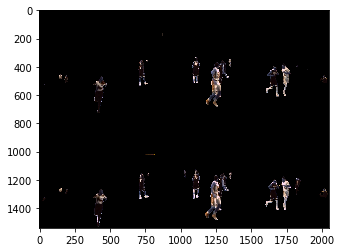

In [134]:
"""y, x = seg_map.shape
for i in range(y):
    for j in range(x):
        if seg_map[i,j]>1:
            #print((i,j))
            seg_map[i,j]=99"""
a=np.concatenate((images[0][0],images[0][1],images[0][2],images[0][3]),1)
b=np.concatenate((images[1][0],images[1][1],images[1][2],images[1][3]),1)
c=np.concatenate((images[2][0],images[2][1],images[2][2],images[2][3]),1)
d=np.concatenate((a,b,c),0)
print(d.shape)
plt.imshow(d)

In [7]:
#for url in glob.glob('*.jpg'):
images = glob.glob('*.jpg')
print(images[0:2])
mask = Image.open(images[1])
mask2 = mask.convert('L')
t2 = Image.open(images[0]).convert('RGBA')
#mask2 = ImageOps.invert(mask2)
print(mask.mode)
print(t2.mode)
t2.save('rbefore.png')
t2.putalpha(mask2)
mask2.save('rthemask.png')
t2.save('result.png')

['cam1000.jpg', 'cam1000_seg.jpg']
L
RGBA
